This bot operates using the same strategy as the Price&VolumeLongbot. However, it can take both short and long positions.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn")

In [39]:
class Long_Short_Backtester():
    ''' Class for the vectorized backtesting of simple Long-Short trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum).
         
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Long_Short_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw
        
    def test_strategy(self, percentiles = None, thresh = None):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        percentiles: tuple (return_low_perc, return_high_perc, vol_low_perc, vol_high_perc)
            return and volume percentiles to be considered for the strategy.
            
        thresh: tuple (return_low_thresh, return_high_thresh, vol_low_thresh, vol_high_thesh)
            return and volume thresholds to be considered for the strategy.
        '''
        
        self.prepare_data(percentiles = percentiles, thresh = thresh)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, percentiles, thresh):
        ''' Prepares the Data for Backtesting.
        '''
        ########################## Strategy-Specific #############################
        
        data = self.data[["Close", "Volume", "returns"]].copy()
        data["vol_ch"] = np.log(data.Volume.div(data.Volume.shift(1)))
        data.loc[data.vol_ch > 3, "vol_ch"] = np.nan
        data.loc[data.vol_ch < -3, "vol_ch"] = np.nan        
        
        if percentiles:
            self.return_thresh = np.percentile(data.returns.dropna(), [percentiles[0], percentiles[1]])
            self.volume_thresh = np.percentile(data.vol_ch.dropna(), [percentiles[2], percentiles[3]])
        elif thresh:
            self.return_thresh = [thresh[0], thresh[1]]
            self.volume_thresh = [thresh[2], thresh[3]]
                
        cond1 = data.returns <= self.return_thresh[0]
        cond2 = data.vol_ch.between(self.volume_thresh[0], self.volume_thresh[1])
        cond3 = data.returns >= self.return_thresh[1]
        
        data["position"] = 0
        data.loc[cond1 & cond2, "position"] = 1
        data.loc[cond3 & cond2, "position"] = -1

        ##########################################################################
        
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            plt.legend(["Buy and Hold multiple", "Strategy multiple"])
            
    def optimize_strategy(self, return_low_range, return_high_range, vol_low_range, vol_high_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        return_low_range: tuple
            tuples of the form (start, end, step size).
        
        return_high_range: tuple
            tuples of the form (start, end, step size).
            
        vol_low_range: tuple
            tuples of the form (start, end, step size).
        
        vol_high_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        
        return_low_range = range(*return_low_range)
        return_high_range = range(*return_high_range)
        vol_low_range = range(*vol_low_range)
        vol_high_range = range(*vol_high_range)
        
        combinations = list(product(return_low_range, return_high_range, vol_low_range, vol_high_range))
         
        performance = []
        for comb in combinations:
            self.prepare_data(percentiles = comb, thresh = None)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["return_low", "return_high", "vol_low", "vol_high"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()
        
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''
        
        best = self.results_overview.nlargest(1, "performance")
        return_perc = [best.return_low.iloc[0], best.return_high.iloc[0]]
        vol_perc = [best.vol_low.iloc[0], best.vol_high.iloc[0]]
        perf = best.performance.iloc[0]
        print("Return_Perc: {} | Volume_Perc: {} | {}: {}".format(return_perc, vol_perc, self.metric, round(perf, 5)))  
        self.test_strategy(percentiles = (return_perc[0], return_perc[1], vol_perc[0], vol_perc[1]))
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
       
        print(100 * "=")
        print("SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = {} | THRESHOLDS = {}, {}".format(self.symbol, np.round(self.return_thresh, 5), np.round(self.volume_thresh, 5)))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)

In [40]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2020-11-25"
tc = -0.00075

In [41]:
tester = Long_Short_Backtester(filepath = filepath, symbol = symbol,
                              start = start, end = end, tc = tc)
tester.test_strategy(percentiles = (10, 90, 5, 20))

SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = [-0.04307  0.0451 ], [-0.56814 -0.31634]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         0.943111
Multiple (Buy-and-Hold):     4.368439
--------------------------------------
Out-/Underperformance:       -3.425328


CAGR:                        -0.017728
Annualized Mean:             -0.017902
Annualized Std:              0.102648
Sharpe Ratio:                -0.172707


## Optimization

In [42]:
tester.optimize_strategy(return_low_range = (2, 20, 2),
                         return_high_range = (80, 98, 2), 
                         vol_low_range = (0, 18, 2), 
                         vol_high_range = (18, 40, 2))

Return_Perc: [18, 82] | Volume_Perc: [0, 38] | Multiple: 1.78063
SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = [-0.02381  0.02758], [-1.1918  -0.13334]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.780625
Multiple (Buy-and-Hold):     4.368439
--------------------------------------
Out-/Underperformance:       -2.587814


CAGR:                        0.192678
Annualized Mean:             0.176348
Annualized Std:              0.234214
Sharpe Ratio:                0.822656


### Now let's take a look how each of the steps in our parameters effected the bot performance

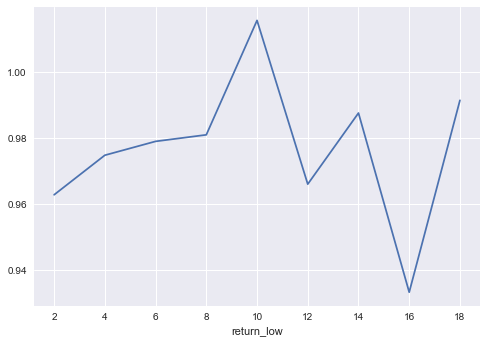

In [43]:
results = tester.results_overview
results.groupby("return_low").performance.mean().plot()
plt.show()

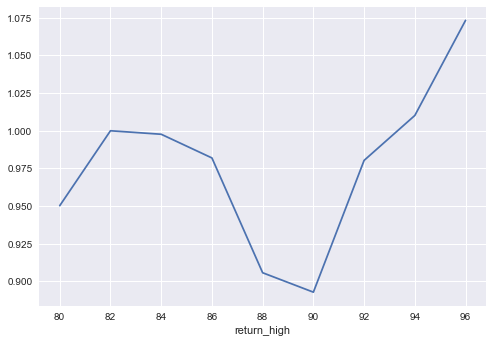

In [44]:
results = tester.results_overview
results.groupby("return_high").performance.mean().plot()
plt.show()

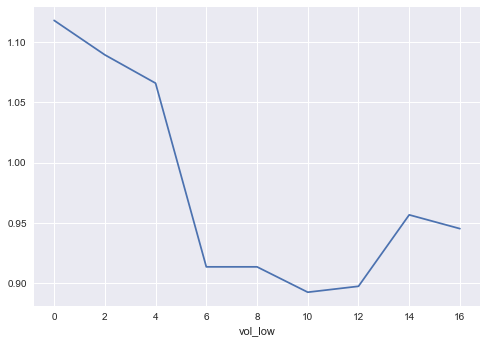

In [45]:
results = tester.results_overview
results.groupby("vol_low").performance.mean().plot()
plt.show()

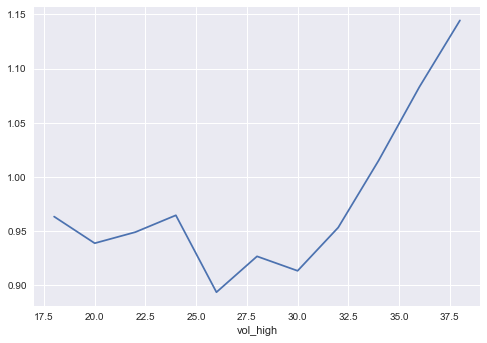

In [46]:
results = tester.results_overview
results.groupby("vol_high").performance.mean().plot()
plt.show()

As we see from the plots, it is best to take a (10%, 96%) log return threshold and (1%, 37%) log volume changes threshold. However, 1st log volume changes percentile is too low, so we will almost never take a long position. Thus, to avoid overfitting, I will take the 4th percentile.

In [47]:
tester.test_strategy((10, 96, 4, 37))

SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = [-0.04307  0.07906], [-0.59766 -0.14178]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.335301
Multiple (Buy-and-Hold):     4.368439
--------------------------------------
Out-/Underperformance:       -3.033138


CAGR:                        0.092323
Annualized Mean:             0.08838
Annualized Std:              0.122647
Sharpe Ratio:                0.752753


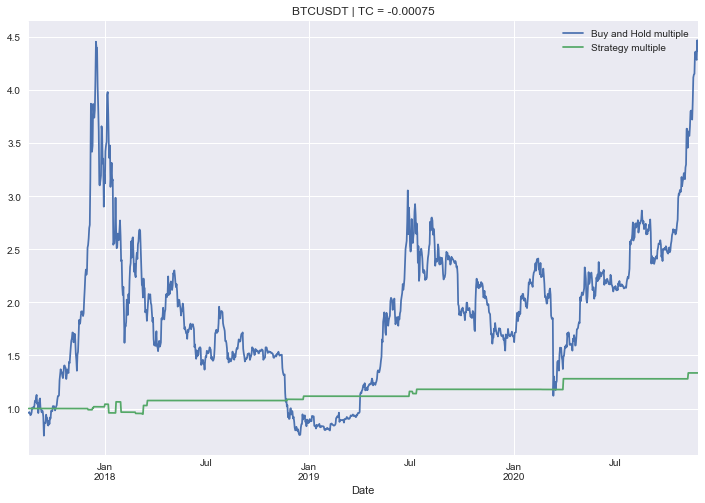

In [48]:
tester.plot_results()

As we see, this strategy is performing poorly compared to the simple buy and hold. However, to be certain, let's also forward test this strategy

## Forward testing

In [49]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2020-11-26"
end = "2021-12-31"
tc = -0.00075

In [50]:
tester = Long_Short_Backtester(filepath = filepath, symbol = symbol, start = start, end = end, tc = tc)
tester.test_strategy((10, 96, 4, 37))

SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = [-0.04635  0.07608], [-0.61256 -0.09812]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.116612
Multiple (Buy-and-Hold):     2.694948
--------------------------------------
Out-/Underperformance:       -1.578336


CAGR:                        0.105964
Annualized Mean:             0.100969
Annualized Std:              0.082321
Sharpe Ratio:                1.2872


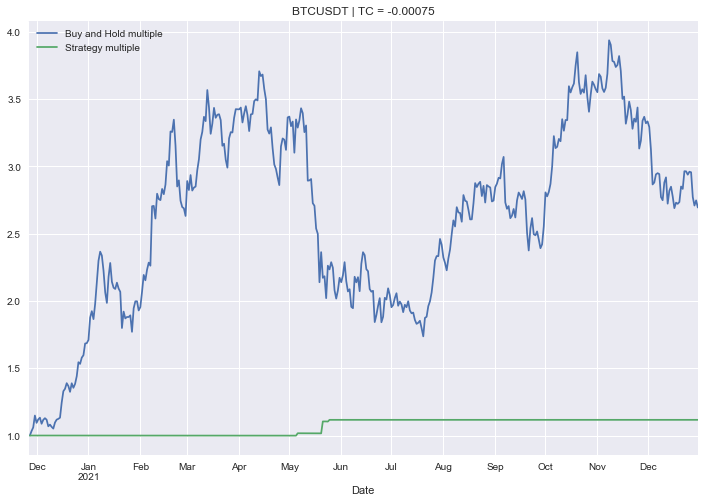

In [51]:
tester.plot_results()

As we see, this strategy is inderperforming on both tests. Thus, it is definitely not valuable.

## Position distribution

In [52]:
tester.results.position.value_counts()

 0    398
-1      3
Name: position, dtype: int64

As we see, we almost always took a neutral position and never took a long position. That's why this strategy performed so poorly.